In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src import *
from sklearn.mixture import GaussianMixture

### random problem instance

In [11]:
def randcov(m, rank=None):
    A = np.random.randn(m, m if rank is None else rank)
    cov = np.dot(A, A.T) / np.sqrt(m) + np.eye(m)
    return cov

N = 30
num_components = 3
dim = 10
rank = 2

weights = np.random.rand(num_components)
weights /= weights.sum()

mus = [5 * np.random.randn(dim) for i in range(len(weights))]
# sigmas = [randcov(dim, rank=rank) for _ in range(len(weights))]
sigmas = [np.eye(dim) for _ in range(len(weights))]


def sample(n):
    out = np.zeros((n, dim))
    for i in range(n):
        k = np.random.choice(len(weights), p=weights)
        out[i] = np.random.multivariate_normal(mus[k], sigmas[k])
    return out

# test data
fit_data = sample(N)
val_data = sample(N)

### fit prior distributions 

In [13]:
# gmm
priors = {}

gmm = GaussianMixture(n_components=num_components)
gmm.fit(fit_data)
priors["gmm"] = gmm

# gmm with post hoc low rank plus diagonal covariances
gmm_post_factor_kl = GaussianMixture(n_components=num_components)
gmm_post_factor_kl.fit(fit_data)
gmm_post_factor_kl = convert_gmm_prior_to_factor_model(gmm_post_factor_kl, rank, metric="kl")
priors["gmm_post_factor_kl"] = gmm_post_factor_kl

gmm_post_factor_heur = GaussianMixture(n_components=num_components)
gmm_post_factor_heur.fit(fit_data)
gmm_post_factor_heur = convert_gmm_prior_to_factor_model(gmm_post_factor_heur, rank, metric="heuristic")
priors["gmm_post_factor_heur"] = gmm_post_factor_heur

gmm_post_factor_frob = GaussianMixture(n_components=num_components)
gmm_post_factor_frob.fit(fit_data)
gmm_post_factor_frob = convert_gmm_prior_to_factor_model(gmm_post_factor_frob, rank, metric="frob")
priors["gmm_post_factor_frob"] = gmm_post_factor_frob

# gmm with factor model constraint on covariances at every EM step
gmm_factor_kl = GaussianFactorMixture(n_components=num_components, rank=rank, metric="kl")
gmm_factor_kl.fit(fit_data)
priors["gmm_factor_kl"] = gmm_factor_kl

gmm_factor_frob = GaussianFactorMixture(n_components=num_components, rank=rank, metric="frob")
gmm_factor_frob.fit(fit_data)
priors["gmm_factor_frob"] = gmm_factor_frob

# this method is dogshit
gmm_factor_heur = GaussianFactorMixture(n_components=num_components, rank=rank, metric="heuristic")
gmm_factor_heur.fit(fit_data)
priors["gmm_factor_heur"] = gmm_factor_heur

for key, prior in priors.items():
    print(f"Method: {key}")
    print(f"Score: {prior.score(val_data)}")

Method: gmm
Score: -217.22472723497233
Method: gmm_post_factor_kl
Score: -217.22472723497233
Method: gmm_post_factor_heur
Score: -217.22472723497233
Method: gmm_post_factor_frob
Score: -217.22472723497233
Method: gmm_factor_kl
Score: -19.329705495401225
Method: gmm_factor_frob
Score: -18.85699584744184
Method: gmm_factor_heur
Score: -23759.39256074965


## Generate volume predictors

In [14]:
vol_preds = {}

# linear regression baseline
lrv = LinearRegressionVolume(dim)
lrv.fit(fit_data)
vol_preds["linreg"] = lrv

for key, prior in priors.items():
    vol_preds[key] = GaussianMixtureVolume(prior)

### Test volume predictors' conditional update

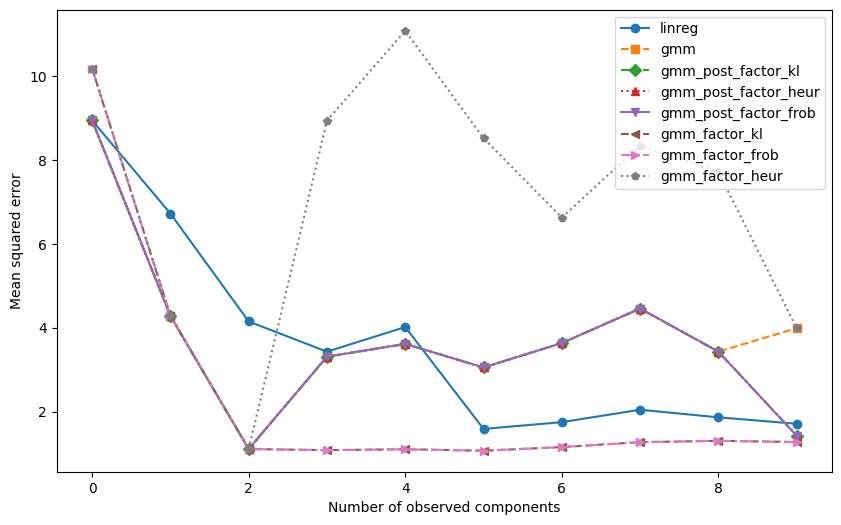

In [24]:
linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+', 'x']

calc_mse = lambda pred, true: np.mean(np.square(true - pred))

plt.figure(figsize=(10, 6))
for j, (key, vol_pred) in enumerate(vol_preds.items()):
    mses = [calc_mse(vol_pred.predict(), val_data)]
    for i in range(dim - 1):
        mses.append(calc_mse(vol_pred.predict(val_data[:, : i + 1]), val_data[:, i + 1 :]))

    plt.plot(mses, linestyle=linestyles[j % len(linestyles)], marker=markers[j % len(markers)], label=key)

plt.xlabel("Number of observed components")
plt.ylabel("Mean squared error")
plt.legend(loc="upper right")
plt.show()